In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pd_reader
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math

%matplotlib inline

In [50]:
## Feed Data into backtrader
ticker = 'AAP'
aapl = pd.read_csv(f".\\bt_stock_data\{ticker}.csv", index_col=0, parse_dates=True)
aapl_feed = bt.feeds.PandasData(dataname=aapl, openinterest=-1)

In [51]:
## Startegy
class BuyAndHoldStrategy(bt.Strategy):
    
    def __init__(self):
        self.pending_orders = dict()
        
    def notify_order(self, order):
        if not order is None:
            if order.status == order.Completed:
                symbol = self.pending_orders[order.ref]
                print('%s: %s order filled' % (self.datetime.date(), symbol))
            
    #! this line of code is part of solution described above
    def prenext(self):
        self.next()
    
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        
        for i, d in enumerate(self.datas):
            
            #! this line of code is part of solution described above
            #! check if instrument is available for trading
            ta = self.datas[i]._dataname['transactionAmounts'].loc[self.datetime.date()]
            tn = self.datas[i]._dataname['numTransactions'].loc[self.datetime.date()]
            can_trade = (( self.datetime.date() in self.datas[i]._dataname.index )
                & ~np.isnan(ta)
                & (tn > 2)
            )
            no_position = not self.getposition(self.datas[i])

            if can_trade:
                volume = self.datas[i]._dataname['volume'].loc[self.datetime.date()]
                prc = self.datas[i]._dataname['close'].loc[self.datetime.date()]
                # we want to allocate $20000 in each instrument, but as order will
                # be executed only at the next days's open price, we leave a margin of $1000
                # to make sure that order will not be cancelled due to lack of cash
                order = self.order_target_value(data=self.datas[i], target=-(ta/100) * tn)
                if not order is None:
                    self.pending_orders[order.ref] = d._name

                print('%s: %s order submitted' % (self.datetime.date(), d._name))       

2018-01-09: AAP order submitted
2018-01-10: AAP order filled
2018-02-05: AAP order submitted
2018-02-06: AAP order filled
2018-03-05: AAP order submitted
2018-03-06: AAP order filled
2018-04-16: AAP order submitted
2018-05-02: AAP order submitted
2018-05-03: AAP order filled
2018-05-31: AAP order submitted
2018-06-01: AAP order filled
2018-07-10: AAP order submitted
2018-07-11: AAP order filled
2018-08-02: AAP order submitted
2018-08-03: AAP order filled
2018-10-09: AAP order submitted
2018-10-10: AAP order filled
2018-11-05: AAP order submitted
2018-11-06: AAP order filled
2019-01-07: AAP order submitted
2019-01-08: AAP order filled
2019-02-05: AAP order submitted
2019-02-06: AAP order filled
2019-03-05: AAP order submitted
2019-03-06: AAP order filled
2019-04-08: AAP order submitted
2019-04-09: AAP order filled
2019-05-16: AAP order submitted
2019-05-17: AAP order filled
2019-07-09: AAP order submitted
2019-07-10: AAP order filled
2019-08-02: AAP order submitted
2019-08-05: AAP order

<IPython.core.display.Javascript object>

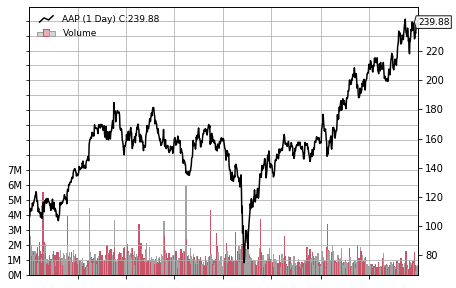

In [52]:
## Initialize backtesting   
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.setcash(100000.0)
cerebro.adddata(aapl_feed, name=ticker)
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

strats = cerebro.run()
cplots = cerebro.plot()

Start date,2018-01-02
End date,2021-12-31
Total months,48
,Backtest
Annual return,-5.9%
Cumulative returns,-21.6%
Annual volatility,37.5%
Sharpe ratio,0.01
Calmar ratio,-0.10
Stability,0.00
Max drawdown,-56.7%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,56.70,2020-03-20,2021-11-15,NaT,NaN
1,44.30,2018-04-20,2020-03-10,2020-03-16,497
2,12.69,2018-03-23,2018-03-29,2018-04-09,12
3,6.53,2020-03-16,2020-03-17,2020-03-18,3
4,5.82,2018-03-08,2018-03-13,2018-03-20,9


Stress Events,mean,min,max
New Normal,0.00%,-12.81%,35.62%


Top 10 long positions of all time,max
AAP,63.28%


Top 10 short positions of all time,max
AAP,-369.40%


Top 10 positions of all time,max
AAP,369.40%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,16.00,15.00,1.00
Percent profitable,0.44,0.47,0.00
Winning round_trips,7.00,7.00,0.00
Losing round_trips,9.00,8.00,1.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-21645.68,$-20862.10,$-783.58
Gross profit,$53243.00,$53243.00,$0.00
Gross loss,$-74888.68,$-74105.10,$-783.58
Profit factor,$0.71,$0.72,$0.00
Avg. trade net profit,$-1352.85,$-1390.81,$-783.58
Avg. winning trade,$7606.14,$7606.14,$nan
Avg. losing trade,$-8320.96,$-9263.14,$-783.58
Ratio Avg. Win:Avg. Loss,$0.91,$0.82,$nan
Largest winning trade,$49929.92,$49929.92,$-783.58
Largest losing trade,$-47063.98,$-47063.98,$-783.58


Duration stats,All trades,Short trades,Long trades
Avg duration,126 days 16:30:00.062500,135 days 01:36:00.066666,1 days
Median duration,126 days 12:00:00,127 days 00:00:00,1 days
Longest duration,232 days 00:00:00,232 days 00:00:00,1 days
Shortest duration,1 days 00:00:00,33 days 00:00:00,1 days


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-3.22%,-3.37%,-0.97%
Avg returns winning,5.45%,5.45%,nan%
Avg returns losing,-9.96%,-11.08%,-0.97%
Median returns all round_trips,-0.38%,-0.22%,-0.97%
Median returns winning,0.18%,0.18%,nan%
Median returns losing,-0.97%,-1.08%,-0.97%
Largest winning trade,35.16%,35.16%,-0.97%
Largest losing trade,-55.53%,-55.53%,-0.97%


Symbol stats,AAP
Avg returns all round_trips,-3.22%
Avg returns winning,5.45%
Avg returns losing,-9.96%
Median returns all round_trips,-0.38%
Median returns winning,0.18%
Median returns losing,-0.97%
Largest winning trade,35.16%
Largest losing trade,-55.53%


Profitability (PnL / PnL total) per name,
symbol,
AAP,100.00%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


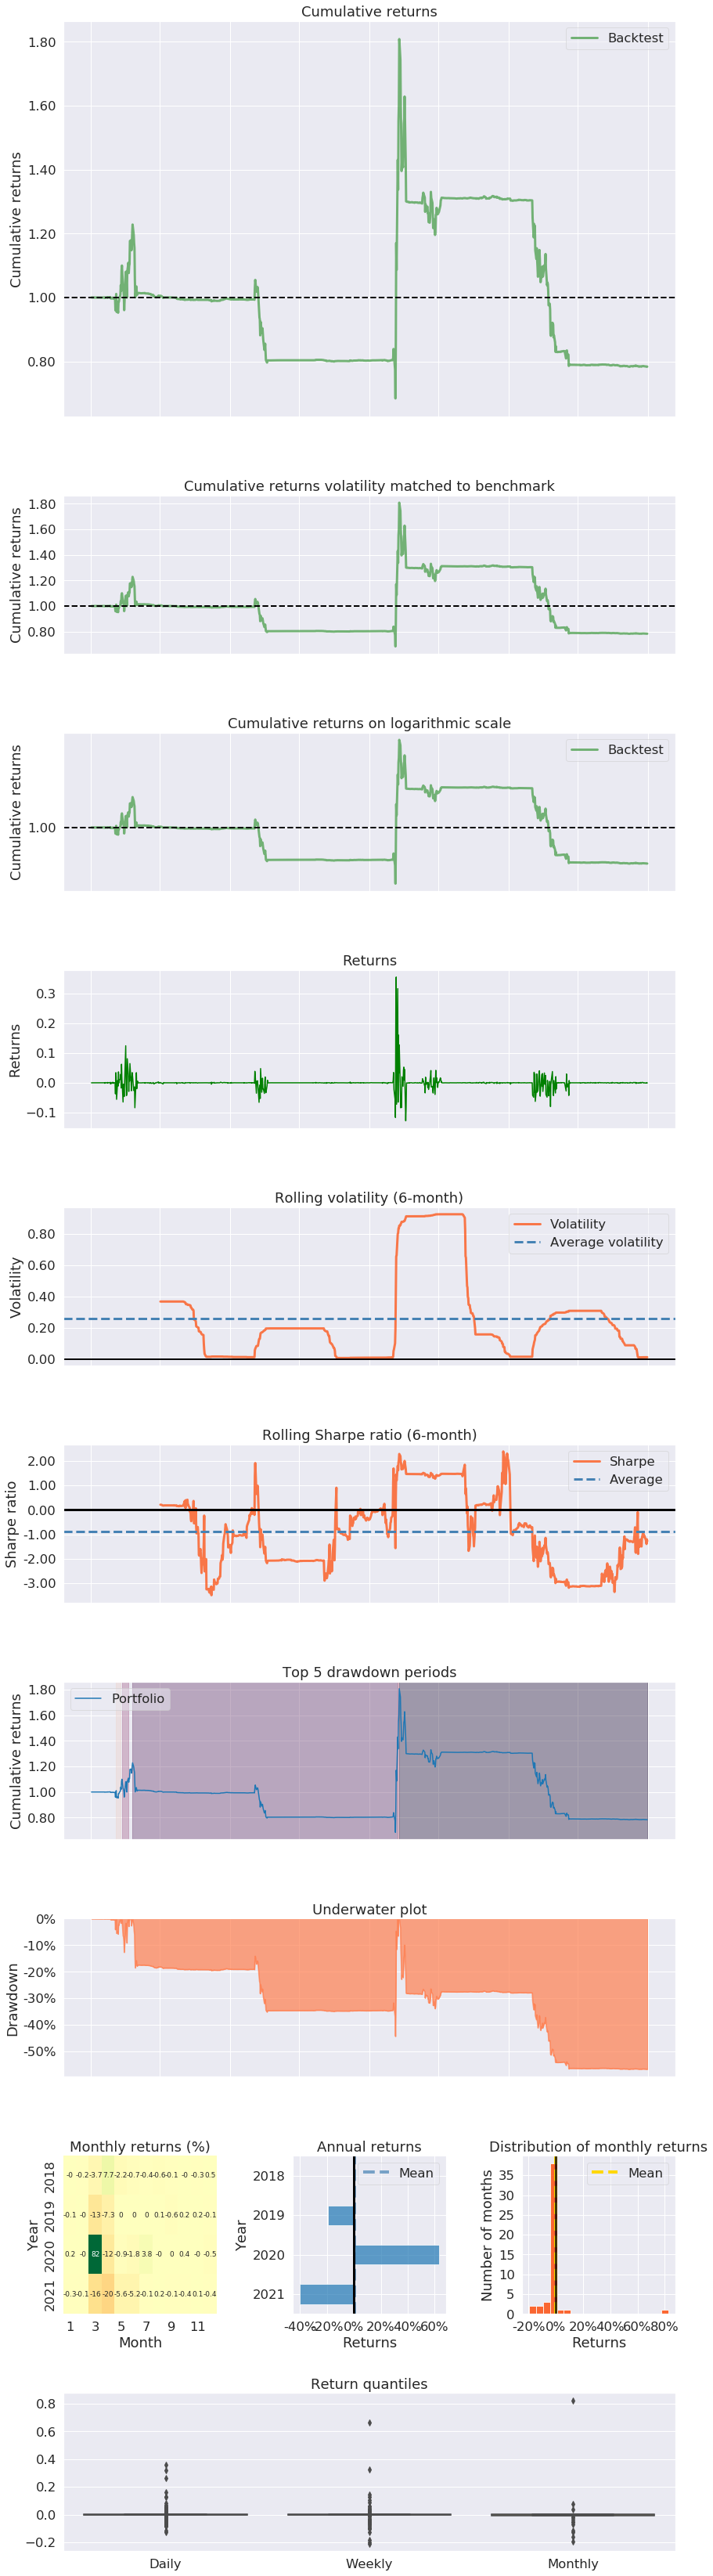

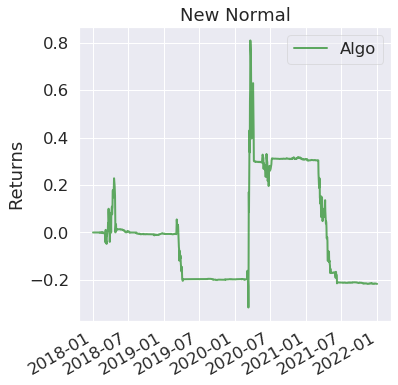

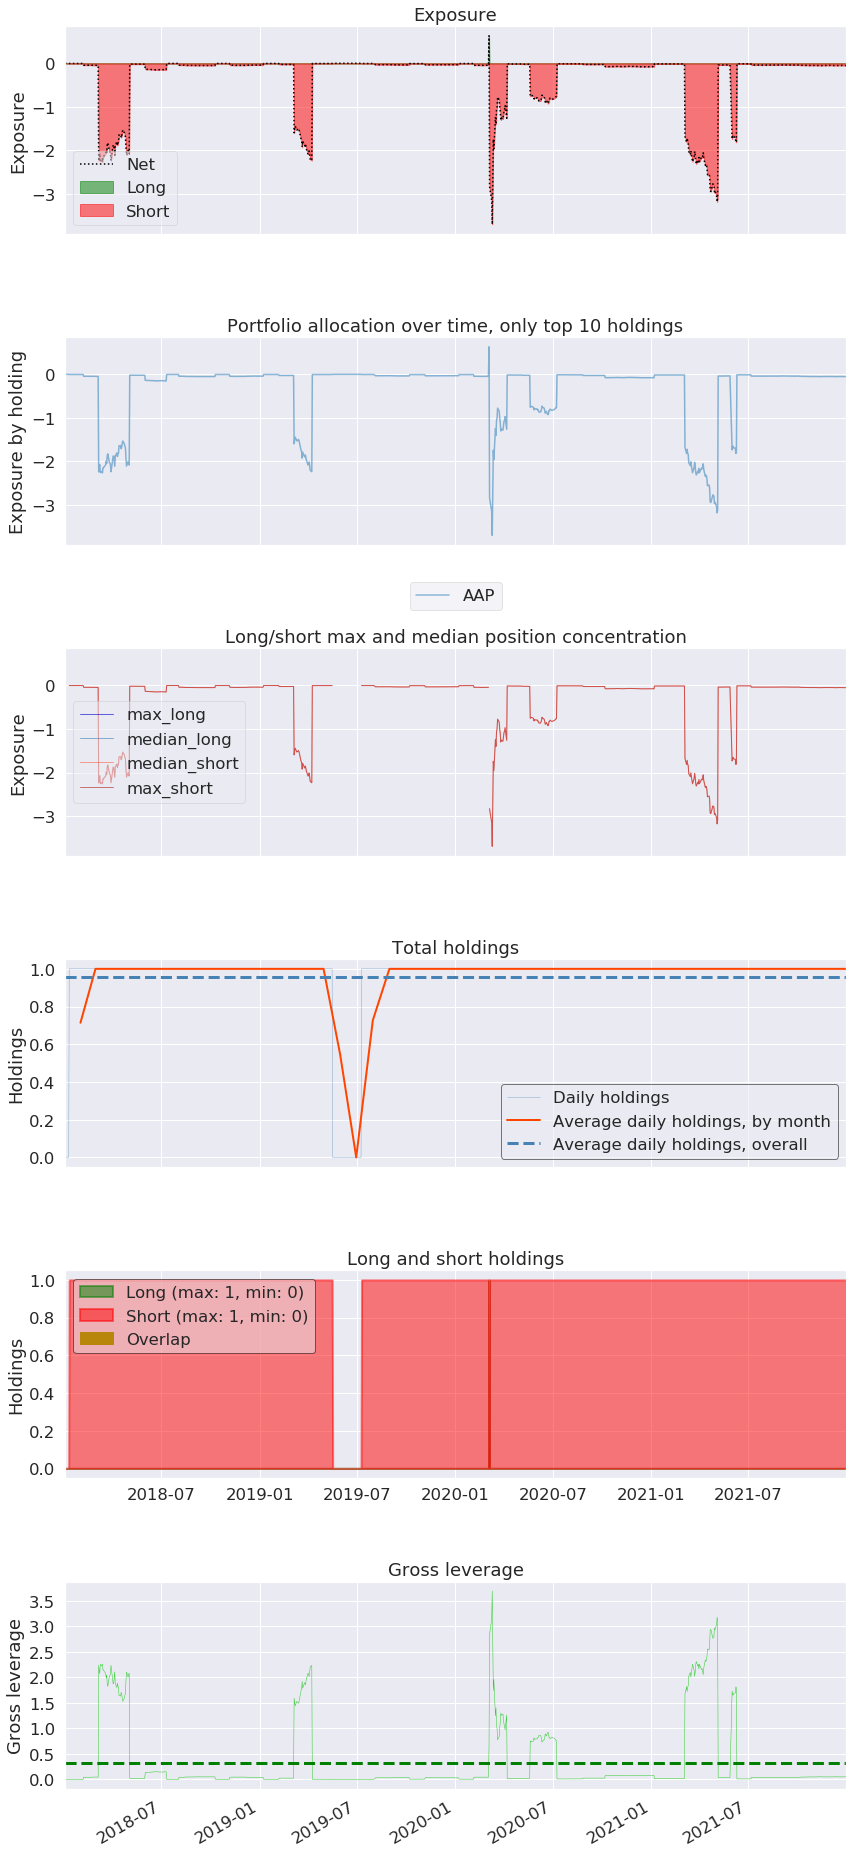

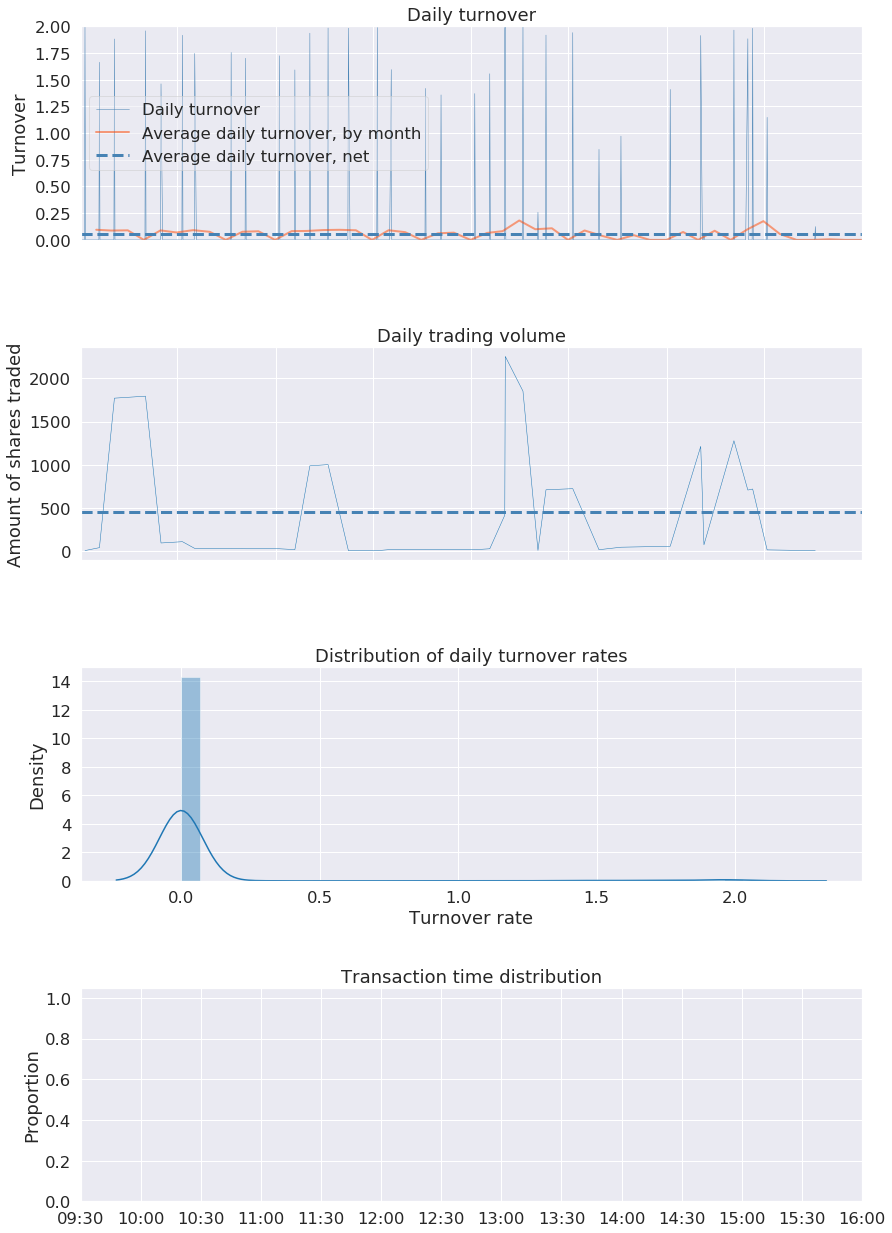

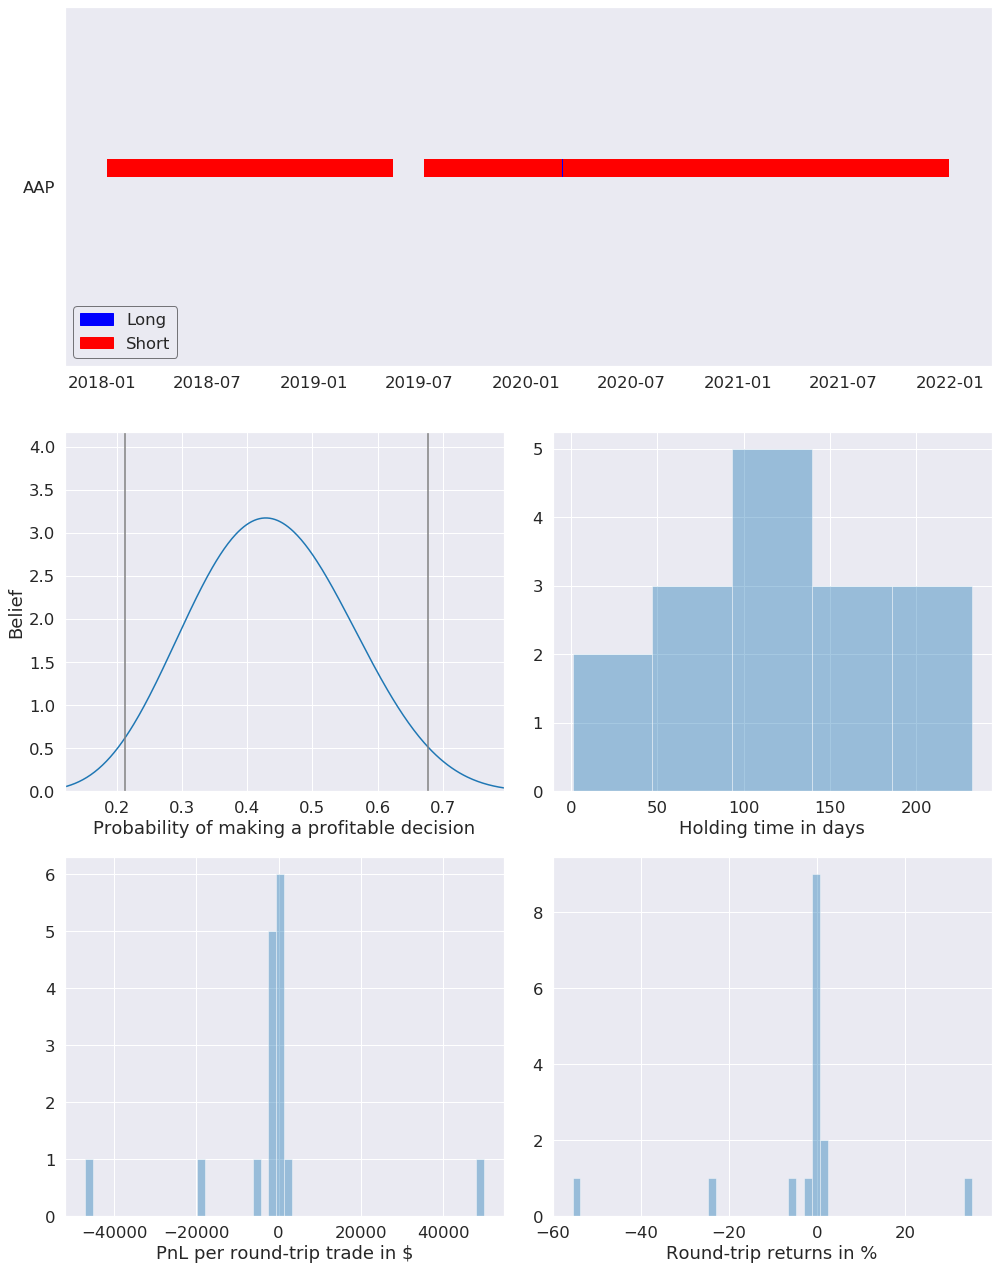

In [53]:
%matplotlib inline
import pyfolio as pf
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2005-05-01',  # This date is sample specific
    round_trips=True)